# Language Warmup Full Model

## Data Cleaning

### Getting the Cleaning Tools Ready

To clean the dataset, we will be using Pandas, NumPy, RegEx, NLTK and an autocorrect library. There are some custom solutions here that will be explained further via inline comments. Here, we are just importing the libraries and even selecting specific modules from some of them.

In [11]:
import pandas as pd
import numpy as np
import string
import re
import nltk

# 'spell' will be our spell checker and corrector for cleaning purposes
from autocorrect import spell

# A stopword for our purposes is a word that doesn't add a lot of insight to the sentiment of a sentence
nltk.download('stopwords')
nltk.download('wordnet')

# A lemmatizer is a way for us to find the root of a word. 
# Using this, 'grows', 'grew', and 'grown' all evaluate to 'grow'.
lm = nltk.WordNetLemmatizer()

stopword = nltk.corpus.stopwords.words('english')

# We are removing the word 'not' to avoid a situation where for example 'not good' == 'good' 
stopword = [word for word in stopword if word != 'not']

[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Reading in the Data

These two lines of code make it really easy to manipulate the dataset by organizing it into labelled columns and rows, called a dataframe. We can create functions to manipulate specific columns, and for our purposes, we'd like to play around with the reviews only. To do that, first we must read in the data. We can use Pandas' **pd.read_csv** as seen below to read a specific file, **Yelp.txt**. We just have to indicate that each colummn is separated by a tab, or **\t** which we have done. **Header** is set to None because we want to read the file from its first line. Finally, encoding has been set to **Latin1**. This is because of a decoding error that was thrown at us. Encoding in another character set seemed to fix the problem and create no new ones, so we didn't look back. 

Now that the dataset is read in, we can name our columns as they appear from left to right by using the **.columns** method in Pandas.

In [12]:
yelpDataset = pd.read_csv('Yelp.txt', sep='\t', header=None, encoding='latin-1')
yelpDataset.columns = ['review', 'sentiment']

### Creating the Cleaning Functions

With our data set up the way it is, our cleaning is made fairly simple. Each of these functions 'reads' each review and then executes its function on each of them. The purpose of each function will be explained with inline comments.

In [13]:
# This function takes each review and breaks it up into its individual words
def tokenize(text):
    tokens = re.split('\W+', text) # '\W' will split on any non-word characters such as a whitespace, comma or period
    return tokens

# This function removes all characters from 'review' that are NOT alaphabetical (special characters, punctuation etc)
def onlyAlpha(tokenizedList):
    text = [word for word in tokenizedList if word.isalpha()]
    return text

# This function removes any instance of a stopword in each review
def noStop(tokenizedList):
    text = [word for word in tokenizedList if word not in stopword]
    return text

# This function checks for and corrects spelling errors in each word of each review
def spellCheck(tokenizedList):
    text = [spell(word) for word in tokenizedList]
    return text

# This function uses the lemmatizer mentioned earlier on each word of each review
def lemmatize(tokenizedList):
    text = ' '.join([lm.lemmatize(word) for word in tokenizedList]) # .join is used at the end to return the tokenized
    return text                                                     # reviews and returning them to full sentences




### Applying the Cleaning Functions

To apply each function, we decided to use lambda functions. Using lambda functions is beneficial here because we are performing a fairly specific sequence of tasks. On the left of each expression we are naming a new column (usually to reflect a change), and on the right, we are applying a function to each row of our specified column. This leaves us with a new column of data with the function applied. 

In [14]:
yelpDataset['review_tokens'] = yelpDataset['review'].apply(lambda x: tokenize(x.lower()))
yelpDataset['review_alpha'] = yelpDataset['review_tokens'].apply(lambda x: onlyAlpha(x))
yelpDataset['review_nostops'] = yelpDataset['review_alpha'].apply(lambda x: noStop(x))
yelpDataset['review_spellCheck'] = yelpDataset['review_nostops'].apply(lambda x: spellCheck(x))
yelpDataset['review_lemmatized'] = yelpDataset['review_spellCheck'].apply(lambda x: lemmatize(x))

### From DataFrame to Separate Lists

Now that the data is clean, in order for our Feature Engineering and Vectorization to proceed we must turn our 2-dimensional DataFrame into two separate lists.

In [15]:
# First, we can turn our DataFrame column into a 1-dimensional DataFrame 
review = pd.DataFrame(data = yelpDataset['review_lemmatized'])

# Now, we can turn our 1-dimensional DataFrame into a list using Pandas' .tolist method
review = review['review_lemmatized'].tolist()

#The same is done to our sentiment column
sentiment = pd.DataFrame(data = yelpDataset['sentiment'])
sentiment = sentiment['sentiment'].tolist()

## Feature Engineering and Vectorization

In [16]:
# Vectorize data, with 1- and 2- grams

from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True, lowercase=False)
#vectorizer = CountVectorizer(binary=True, lowercase=False, ngram_range=(1, 2))
vector = vectorizer.fit_transform(review)

In [17]:
# Change to a numpy array

data = vector.todense()
data = np.asarray(data)
print(type(data))

<class 'numpy.ndarray'>


In [18]:
# Split into train, test, and validate sets

x_train = np.concatenate([data[:300], data[-300:]])
y_train = np.concatenate([df2[:300], df2[-300:]])
x_val = np.concatenate([data[300:400], data[600:700]])
y_val = np.concatenate([df2[300:400], df2[600:700]])
x_test = np.concatenate([data[400:600]])
y_test = np.concatenate([df2[400:600]])
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(600, 1741)
(200, 1741)
(200, 1741)


## Model Architecture

### Model Creation 

This is where we finally make our neural network to process the vectorized data we made above. This process will consist of importing the libraries we need (keras in our instance), selecting the kind of model we wish to work with, creating the nueral network with it number of nodes and layers, selecting optimizer, loss, and metric functions, training, and then finally testing our data.

In [19]:
#Import the models library from the keras main library to use for our model
from keras import models

#Import the layers library from the keras main library, this will allow us to create a sequential neural network with sequential layers
from keras import layers


#Will make our model a sequential model, with sequences of dense layers
model = models.Sequential()

#Will set the first layer as a dense layer with 16 nodes, will use the activation function relu and fit our layer to the data
#Worth noting here that the number of layers and number of nodes are rather arbitrary, from our experience
#with this particular model, 1 dense layer with 16 nodes each allowed for maximal accuracy in the test data
#Will then output a single node dense layer that will output a continuous probability curve via the sigmoid function activator

model.add(layers.Dense(16, activation = 'relu', input_shape = (x_train.shape[1],)))
model.add(layers.Dense(1,  activation = 'sigmoid'))

### Model Compilation

Now that we have made our model, we must now choose what we want as our metric, our loss function, and our optimizer functions.

Very large degree of freedom here, many different loss functions to use, as well as metrics for model evaluation
and optimizer functions.

From our experience with this model, was more useful to use the following optimizer, loss, and metric functions,
but this can vary depending upon the project you are working on.

In [20]:
model.compile(optimizer = 'rmsprop',           #Set our optimizer function as "rmsprop"
              loss = 'binary_crossentropy',    #Set up our loss function as "binary cross entropy"
              metrics = ['accuracy'])          #Set up our metric function, will use "accuracy" here

### Model Training
Now that we have created our model and defined how we will evaluate our model and how it will optimize loss, will now train it.

To keep track of how our model is doing, will want to print out a history of each epoch to see how our model is improving, and if it is overfitting.

To train the model, must give our model the x_train and y_train data we set aside earlier, set a number of epochs we wish for the model to go through, the number of data entries per epoch, and (optionally), have it analyze a vlaidation set.

Again, worth noting here that the number of epochs and batch size are completely aribtrary and will vary form model to model, from our experience, we wished to maximize accuracy, so a greater number of epochs was desirable 

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 0s 514us/step - loss: 0.6864 - acc: 0.5550 - val_loss: 0.6871 - val_acc: 0.5500
Epoch 2/20
600/600 [==============================] - 0s 70us/step - loss: 0.6621 - acc: 0.7067 - val_loss: 0.6806 - val_acc: 0.5950
Epoch 3/20
600/600 [==============================] - 0s 80us/step - loss: 0.6407 - acc: 0.7667 - val_loss: 0.6728 - val_acc: 0.6250
Epoch 4/20
600/600 [==============================] - 0s 81us/step - loss: 0.6186 - acc: 0.8100 - val_loss: 0.6636 - val_acc: 0.6500
Epoch 5/20
600/600 [==============================] - 0s 66us/step - loss: 0.5952 - acc: 0.8500 - val_loss: 0.6523 - val_acc: 0.6850
Epoch 6/20
600/600 [==============================] - 0s 78us/step - loss: 0.5706 - acc: 0.8883 - val_loss: 0.6412 - val_acc: 0.7150
Epoch 7/20
600/600 [==============================] - 0s 64us/step - loss: 0.5452 - acc: 0.9017 - val_loss: 0.6293 - val_acc: 0.7350
Epoch 8/20
600/600 [==

(0, 20)

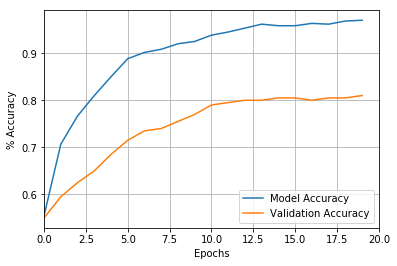

In [21]:
history = model.fit(x_train,                            #Input the x_train data
                       y_train,                         #Input the y_train data (features)
                       epochs=20,                       #Set our model to go through 20 epochs
                       batch_size=64,                   #Set our epoch batch size to 64 data entires
                       validation_data=(x_val, y_val))  #Have our model also go through the validation set, x_val, y_val

#To prevent overfitting, will plot the model accuracy against the validation accuracy and see where divergence occurs

#Will use the matplotlib.pyplot library to access the necessary plotting functions we will need to plot our output

import matplotlib.pyplot as plt

#Plot the model accuracy by calling history.history['acc']
plt.plot(history.history['acc'], label = "Model Accuracy")

#Add the validation accurayc to our plot by calling history.history['val_acc']
plt.plot(history.history['val_acc'], label = "Validation Accuracy")

#Add a grid to the plot for neatness in analysis
plt.grid()

#Add a legend to our plot
plt.legend()

#Adding a label to the x-axis 
plt.xlabel("Epochs")

#Adding a label to the y-axis
plt.ylabel("% Accuracy")

#Adding a limit to the x-axis range, want to make sure we get the full 0-20 epoch range
plt.xlim(0,20)

### Model Testing

Now that we have tried to prevent overfitting the data and have trained it, let's see how well it does on our test data set.

In [22]:
#This step is as simple as calling the evaluate function from the keras models library with our x_test and y_test data sets
#as parameters to pass in
results = model.evaluate(x_test, y_test)

#We've tested it, now let's print out how accurate our model is on the testing data set
print ("Accuracy:", results[1])

200/200 [==============================] - 0s 52us/step
Accuracy: 0.8
